## Лабораторная работа №3. Feature engineering. Part 2.

### Задание.
***
**Цель лабораторной работы:** изучение продвинутых способов предварительной обработки данных для дальнейшего формирования моделей.

**Задание:**  
Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
1. масштабирование признаков (не менее чем тремя способами);  
2. обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);  
3. обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);  
4. отбор признаков:  
  * один метод из группы методов фильтрации (filter methods);  
  * один метод из группы методов обертывания (wrapper methods);  
  * один метод из группы методов вложений (embedded methods).

### Выполнение.
***
Задание буду выполнять на датасете ["Computer Parts (CPUs and GPUs)"](https://www.kaggle.com/iliassekkaf/computerparts). Датасет содержит значения различных характеристик по CPU GPU. C данным датасетом я работал в ЛР2, а в данной ЛР я продолжу обрабатывать данный датасет, используя сохраненные наработки из ЛР2.

Загрузка и обзор датасета, сохраненного в конце ЛР2:

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()
    
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

dataset = pd.read_csv('../data/cpu-dataset-from-lr2.csv', sep=",")
dataset

,Product_Collection,Vertical_Segment,Status,Launch_Date,Lithography,nb_of_Cores,Processor_Base_Frequency,Cache,TDP,Embedded_Options_Available,T,Intel_Hyper_Threading_Technology_,Intel_Virtualization_Technology_VTx_,Intel_64_,Instruction_Set,T_bc
0,13,Mobile,927,Q3'16,14 nm,2,1.30 GHz,4 MB SmartCache,4.5 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
1,15,Mobile,927,Q3'17,14 nm,4,1.60 GHz,6 MB SmartCache,15 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
2,16,Mobile,927,Q3'17,14 nm,4,1.80 GHz,8 MB SmartCache,15 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
3,29,Desktop,415,Q1'12,32 nm,4,3.60 GHz,10 MB SmartCache,130 W,No,66.8,Yes,Yes,Yes,64-bit,4.201703
4,12,Mobile,927,Q1'17,14 nm,2,1.20 GHz,4 MB SmartCache,4.5 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,10,Mobile,927,Q3'15,14 nm,2,1.10 GHz,4 MB SmartCache,4.5 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
2054,10,Mobile,927,Q3'15,14 nm,2,1.10 GHz,4 MB SmartCache,4.5 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
2055,10,Mobile,927,Q3'15,14 nm,2,1.20 GHz,4 MB SmartCache,4.5 W,No,100.0,Yes,Yes,Yes,64-bit,4.605170
2056,6,Mobile,927,Q1'15,14 nm,2,2.00 GHz,4 MB SmartCache,15 W,No,105.0,Yes,Yes,Yes,64-bit,4.653960


### Обработка одного нестандартного признака.  
***
Таким признаком (помимо Т, обработанного в ЛР2) является признак *Processor_Base_Frequency*. В датасете это не числовое значение (type `object`), но на деле представляет собой `float` значение. Причем частоты представлены в MHz и GHz, что также требует конвертации.  
Попробуем распрарсить числовые значения и привести их к одинаковой размерности - MHz.

In [2]:
dataset["Processor_Base_Frequency"].value_counts()

2.00 GHz    116
2.40 GHz    108
1.60 GHz    101
2.80 GHz     98
2.20 GHz     83
           ... 
433 MHz       1
633 MHz       1
1.75 GHz      1
1.07 GHz      1
930 MHz       1
Name: Processor_Base_Frequency, Length: 91, dtype: int64

In [3]:
regex_ghz = r"[0-9\.]*(?= GHz)"
regex_mhz = r"[0-9\.]*(?= MHz)"
col_name = "Processor_Base_Frequency"
for val in dataset[col_name]:
    if type(val) is not str:
        continue
    match = re.search(regex_ghz, str(val))
    if match:
        dataset[col_name] = dataset[col_name].replace([val], float(match.group()) * 1000)
    else:
        match = re.search(regex_mhz, str(val))
        if not match:        
            raise BaseException("Не удалось распарсить {}".format(val))
        else:
            dataset[col_name] = dataset[col_name].replace([val], float(match.group()))
dataset[col_name] = dataset[col_name].astype(int)

In [4]:
dataset["Processor_Base_Frequency"].value_counts()

2000    116
2400    108
1600    101
2800     98
2200     83
       ... 
2170      1
1750      1
766       1
1070      1
1910      1
Name: Processor_Base_Frequency, Length: 91, dtype: int64

### Масштабирование признаков.  
***
Выделим признаки, которые необходимо масштабировать:

In [5]:
dataset_num = dataset[["nb_of_Cores", "Processor_Base_Frequency", "T", "T_bc"]]

In [6]:
dataset_num

,nb_of_Cores,Processor_Base_Frequency,T,T_bc
0,2,1300,100.0,4.605170
1,4,1600,100.0,4.605170
2,4,1800,100.0,4.605170
3,4,3600,66.8,4.201703
4,2,1200,100.0,4.605170
...,...,...,...,...
2053,2,1100,100.0,4.605170
2054,2,1100,100.0,4.605170
2055,2,1200,100.0,4.605170
2056,2,2000,105.0,4.653960


Масштабирование данных на основе Z-оценки (используем `StandardScaler`):

In [7]:
standard_scaler = StandardScaler()
dataset_num_ss = pd.DataFrame(standard_scaler.fit_transform(dataset_num), columns=dataset_num.columns)
dataset_num_ss.describe()

,nb_of_Cores,Processor_Base_Frequency,T,T_bc
count,2.058000e+03,2.058000e+03,2.058000e+03,2.058000e+03
mean,1.009127e-15,-2.717835e-16,-2.123342e-16,4.099949e-17
std,1.000243e+00,1.000243e+00,1.000243e+00,1.000243e+00
min,-5.097813e-01,-2.557890e+00,-2.142569e+00,-2.503936e+00
25%,-3.143762e-01,-7.507757e-01,-9.487338e-01,-9.123622e-01
50%,-3.143762e-01,9.945685e-03,2.385053e-01,3.142552e-01
75%,7.643397e-02,7.802964e-01,8.980825e-01,8.934207e-01
max,1.336398e+01,2.577781e+00,1.557660e+00,1.417340e+00


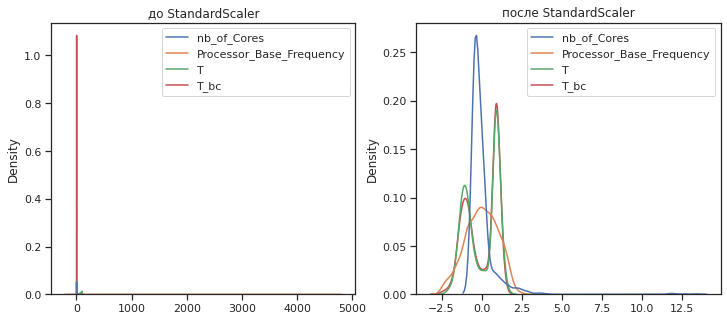

In [8]:
draw_kde(dataset_num.columns, dataset_num, dataset_num_ss, "до StandardScaler", "после StandardScaler")

MinMax-масштабирование данных (используем `MinMaxScaler`):

In [9]:
min_max_scaler = MinMaxScaler()
dataset_num_mm = pd.DataFrame(min_max_scaler.fit_transform(dataset_num), columns=dataset_num.columns)
dataset_num_mm.describe()

,nb_of_Cores,Processor_Base_Frequency,T,T_bc
count,2058.000000,2058.000000,2058.000000,2058.000000
mean,0.036744,0.498063,0.579037,0.638551
std,0.072096,0.194764,0.270319,0.255081
min,0.000000,0.000000,0.000000,0.000000
25%,0.014085,0.351875,0.322638,0.405882
50%,0.014085,0.500000,0.643494,0.718692
75%,0.042254,0.650000,0.821747,0.866391
max,1.000000,1.000000,1.000000,1.000000


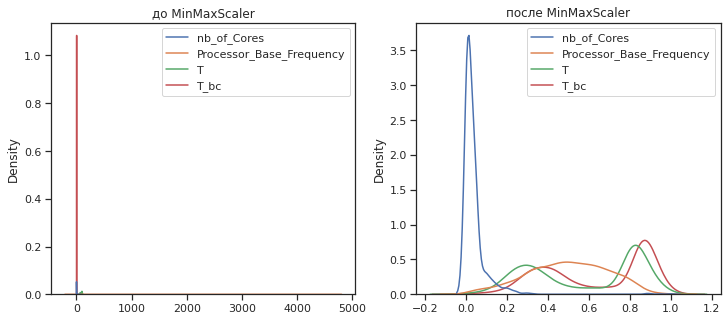

In [10]:
draw_kde(dataset_num.columns, dataset_num, dataset_num_mm, "до MinMaxScaler", "после MinMaxScaler")

Масштабирование по медиане (используем `RobustScaler`):

In [11]:
robust_scaler = RobustScaler()
dataset_num_r = pd.DataFrame(robust_scaler.fit_transform(dataset_num), columns=dataset_num.columns)
dataset_num_r.describe()

,nb_of_Cores,Processor_Base_Frequency,T,T_bc
count,2058.000000,2058.000000,2058.000000,2058.000000
mean,0.804422,-0.006496,-0.129144,-0.174027
std,2.559409,0.653296,0.541604,0.553911
min,-0.500000,-1.677149,-1.289286,-1.560648
25%,0.000000,-0.496855,-0.642857,-0.679272
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.503145,0.357143,0.320728
max,35.000000,1.677149,0.714286,0.610862


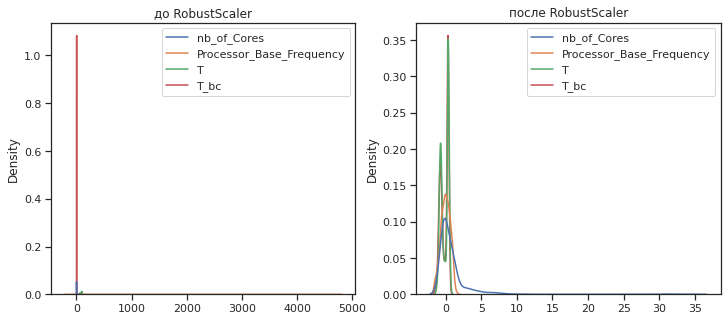

In [12]:
draw_kde(dataset_num.columns, dataset_num, dataset_num_r, "до RobustScaler", "после RobustScaler")

### Обработка выбросов
***